Reading classics [Deep Learning Models](https://nbviewer.jupyter.org/github/rasbt/deeplearning-models/blob/master/pytorch_ipynb/gnn/gnn-basic-graph-spectral-1.ipynb)

[Google Colaboratory Variant](https://colab.research.google.com/drive/1JLI64BVp6W-3XL4wfCUX3sfXXYU7iVpb)

In [1]:
from IPython.display import display,HTML
def dhtml(str):
    display(HTML("""<style>
    @import 'https://fonts.googleapis.com/css?family=Wallpoet&effect=3d';      
    </style><h1 class='font-effect-3d' 
    style='font-family:Wallpoet; color:#33ff55;'>
    %s</h1>"""%str))

In [2]:
dhtml('Code Modules, Functions, & Classes')

In [3]:
import numpy as np,pandas as pd,pylab as pl
import h5py,torch
from torchvision.datasets import MNIST as tmnist
from torchvision import transforms,utils
from torch.utils.data import DataLoader as tdl
from torch.utils.data import Dataset as tds
import torch.nn.functional as tnnf
import torch.nn as tnn
from torch.utils.data.dataset import Subset
import tensorflow.image as timage
from scipy.spatial.distance import cdist
from scipy.sparse.linalg import eigsh
from IPython.core.magic import register_line_magic
dev=torch.device("cuda:0" \
if torch.cuda.is_available() else "cpu")

In [4]:
class TData(tds):
    def __init__(self,x,y):   
        self.x=torch.tensor(x,dtype=torch.float32)
        self.y=torch.tensor(y,dtype=torch.int32)
    def __getitem__(self,index):
        img,lbl=self.x[index],self.y[index]
        return img,lbl
    def __len__(self):
        return self.y.shape[0]

In [5]:
@register_line_magic
def display_examples(n):
    if n=='1': data_loader=train_loader1
    if n=='2': data_loader=train_loader2
    for images,labels in data_loader:  
        print('Image dimensions: %s'%str(images.shape))
        print('Label dimensions: %s'%str(labels.shape))
        n=np.random.randint(1,50)
        fig=pl.figure(figsize=(10,4))
        for i in range(n,n+5):
            ax=fig.add_subplot(1,5,i-n+1,\
            xticks=[],yticks=[],title=labels[i].item())
            ax.imshow((images[i]).reshape(img_size,img_size),
                      cmap=pl.cm.Greens)
        break

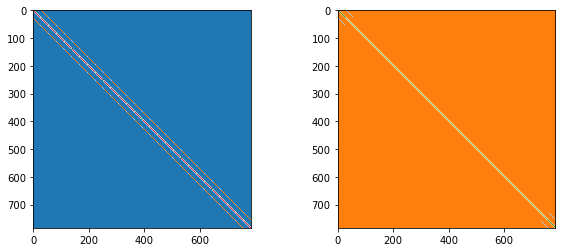

In [6]:
def calc_adjacency_matrix(img_size):
    col,row=np.meshgrid(np.arange(img_size),
                        np.arange(img_size))
    coord=np.stack((col,row),axis=2)\
    .reshape(-1,2)/img_size
    dist=cdist(coord,coord,metric='euclidean')
    sigma=.05*np.pi
    A=np.exp(-dist/sigma**2)
    A[A<.01]=0
    return torch.from_numpy(A).float()
def laplacian_graph(A):
    A=A.numpy()
    N=A.shape[0]; D=np.sum(A,0)
    D_hat=np.diag((D+1e-5)**(-.5))
    L=np.identity(N)-np.dot(D_hat,A).dot(D_hat)
    return torch.from_numpy(L).float()
A=calc_adjacency_matrix(28)
fig=pl.figure(figsize=(10,4))
ax=fig.add_subplot(1,2,1)
ax.imshow(A,cmap='tab20')
ax=fig.add_subplot(1,2,2)
ax.imshow(laplacian_graph(A),cmap='tab20');

In [7]:
def model_acc(model,data_loader):
    correct_preds,num_examples=0,0    
    for features,targets in data_loader:
        features=features.to(dev)
        targets=targets.to(dev).long()
        logits,probs=model(features)
        _,pred_labels=torch.max(probs,1)
        num_examples+=targets.size(0)
        correct_preds+=(pred_labels==targets).sum()        
    return correct_preds.float()/num_examples*100
@register_line_magic
def print_acc(n):
    if int(n)==1:
        data_loader=\
        [train_loader1,valid_loader1,test_loader1]
    if int(n)==2:
        data_loader=\
        [train_loader2,valid_loader2,test_loader2]
    print('Train accuracy: %.4f%%'%\
    (model_acc(model,data_loader[0])))
    print('Valid accuracy: %.4f%%'%\
    (model_acc(model,data_loader[1])))
    print('Test accuracy: %.4f%%'%\
    (model_acc(model,data_loader[2])))

In [8]:
@register_line_magic
def fit_plot(pars):
    if pars=='loss':
        pl.plot(lcost,label='Minibatch Cost')
        pl.plot(np.convolve(lcost,np.ones(200,)/200,
                            mode='valid'), 
                label='Running Average')
        pl.ylabel('Cross Entropy')
        pl.xlabel('Iterations')
    if pars=='acc':
        pl.plot(lacc_train,label='Train Acc')
        pl.plot(lacc_valid,label='Valid Acc')        
        pl.ylabel('Accuracy')
        pl.xlabel('Epochs')
    pl.grid(); pl.legend()

In [9]:
dhtml('Data')

In [10]:
img_size=28
random_seed=12; batch_size1=256
train_ids=torch.arange(0,57000)
valid_ids=torch.arange(57000,60000)
trans=transforms\
.Compose([transforms.Resize((img_size,img_size)),
          transforms.ToTensor()])
train_valid=tmnist(root='data',train=True,
                   download=True,
                   transform=trans)
train1=Subset(train_valid,train_ids)
valid1=Subset(train_valid,valid_ids)
test1=tmnist(root='data',train=False, 
             transform=trans)
train_loader1=tdl(dataset=train1,shuffle=True, 
                  batch_size=batch_size1)
valid_loader1=tdl(dataset=valid1,shuffle=True, 
                  batch_size=batch_size1)
test_loader1=tdl(dataset=test1,shuffle=False, 
                 batch_size=batch_size1)

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw




Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


/opt/conda/conda-bld/pytorch_1591914880026/work/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


Image dimensions: torch.Size([256, 1, 28, 28])
Label dimensions: torch.Size([256])




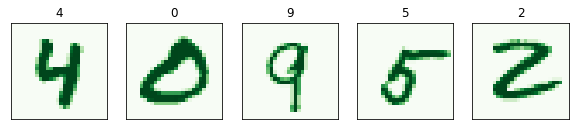

In [11]:
%display_examples 1

In [12]:
fpath='../input/classification-of-handwritten-letters/'
f='LetterColorImages_123.h5'
f=h5py.File(fpath+f,'r')
keys=list(f.keys()); print(keys)
x=1-np.array(f[keys[1]],dtype='float32')/255
x=timage.resize(x,[img_size,img_size])
x=(np.dot(x.numpy(),[.299,.587,.114]))\
.reshape(-1,1,img_size,img_size)
y=np.array(f[keys[2]],dtype='int32')-1
N=len(y); n=int(.1*N)
shuffle_ids=np.arange(N)
np.random.RandomState(23).shuffle(shuffle_ids)
x,y=x[shuffle_ids],y[shuffle_ids]
x_test,x_valid,x_train=x[:n],x[n:2*n],x[2*n:]
y_test,y_valid,y_train=y[:n],y[n:2*n],y[2*n:]
random_seed=23; batch_size2=64
train2=TData(x_train,y_train)
valid2=TData(x_valid,y_valid)
test2=TData(x_test,y_test)
train_loader2=tdl(dataset=train2,shuffle=True,
                  batch_size=batch_size2)
valid_loader2=tdl(dataset=valid2,shuffle=True,
                  batch_size=batch_size2)
test_loader2=tdl(dataset=test2,shuffle=False,
                 batch_size=batch_size2)

['backgrounds', 'images', 'labels']


Image dimensions: torch.Size([64, 1, 28, 28])
Label dimensions: torch.Size([64])


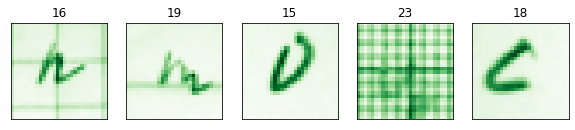

In [13]:
%display_examples 2

In [14]:
dhtml('Basic Graph Neural Networks <br/>with Spectral Graph Convolution')

In [15]:
class GraphNN(tnn.Module):
    def __init__(self,img_size,num_filters,num_classes):
        super(GraphNN,self).__init__()
        num_rows=img_size**2
        self.fc=tnn.Linear(num_rows*num_filters,
                           num_classes,bias=False)
        A=calc_adjacency_matrix(img_size)
        L=laplacian_graph(A)
        Λ,V=eigsh(L.numpy(),k=20,which='SM')
        V=torch.from_numpy(V)
        W_spectral=tnn.Parameter(torch\
        .ones((num_rows,num_filters))).float()
        tnn.init.kaiming_uniform_(W_spectral)      
        self.register_buffer('A',A)
        self.register_buffer('L',L)
        self.register_buffer('V',V)
        self.register_buffer('W_spectral',W_spectral)
    def forward(self,x): 
        B=x.size(0)
        V_tensor=self.V.unsqueeze(0)
        V_tensor=self.V.expand(B,-1,-1)
        V_tensor_T=self.V.T.unsqueeze(0)
        V_tensor_T=self.V.T.expand(B,-1,-1)
        x_reshape=x.view(B,-1,1)
        W_spectral_tensor=self.W_spectral.unsqueeze(0)
        W_spectral_tensor=self.W_spectral.expand(B,-1,-1)
        X_hat=V_tensor_T.bmm(x_reshape)
        W_hat=V_tensor_T.bmm(W_spectral_tensor)
        Y=V_tensor.bmm(X_hat *W_hat)
        logits=self.fc(Y.reshape(B,-1))
        probs=tnnf.softmax(logits,dim=1)
        return logits,probs

In [16]:
dhtml('Training')

In [17]:
@register_line_magic
def train_run(pars):
    [n,epochs]=[int(el) for el in pars.split()]
    if n==1:
        train_loader=train_loader1
        valid_loader=valid_loader1
        train=train1; batch_size=batch_size1
    if n==2:
        train_loader=train_loader2
        valid_loader=valid_loader2
        train=train2; batch_size=batch_size2
    for epoch in range(epochs):
        model.train()
        for batch_ids,(features,targets) in enumerate(train_loader):        
            features=features.to(dev)
            targets=targets.to(dev).long()
            logits,probs=model(features)
            cost=tnn.functional.cross_entropy(logits,targets)
            optimizer.zero_grad()
            cost.backward(); lcost.append(cost.item())
            optimizer.step()
            if not batch_ids%100:
                print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
                       %(epoch+1,epochs,batch_ids, 
                         len(train)//batch_size,cost))
        model.eval()
        with torch.set_grad_enabled(False):
            train_acc=model_acc(model,train_loader)
            valid_acc=model_acc(model,valid_loader)
            print('Epoch: %03d/%03d train acc: %.2f%% valid acc: %.2f%%'%\
                  (epoch+1,epochs,train_acc,valid_acc))
            lacc_train.append(train_acc)
            lacc_valid.append(valid_acc)

In [18]:
torch.manual_seed(random_seed)
num_classes=10; num_filters=3
learning_rate=.05
lcost,lacc_train,lacc_valid=[],[],[]
model=GraphNN(img_size=img_size,
              num_filters=num_filters,
              num_classes=num_classes)
model=model.to(dev)
optimizer=torch.optim.SGD(model.parameters(),
                          lr=learning_rate) 

In [19]:
%train_run 1 70

Epoch: 001/070 | Batch 000/222 | Cost: 2.2945
Epoch: 001/070 | Batch 100/222 | Cost: 1.3759
Epoch: 001/070 | Batch 200/222 | Cost: 1.2522
Epoch: 001/070 train acc: 71.84% valid acc: 75.90%
Epoch: 002/070 | Batch 000/222 | Cost: 1.1585
Epoch: 002/070 | Batch 100/222 | Cost: 1.0926
Epoch: 002/070 | Batch 200/222 | Cost: 0.9932
Epoch: 002/070 train acc: 74.50% valid acc: 78.67%
Epoch: 003/070 | Batch 000/222 | Cost: 0.9267
Epoch: 003/070 | Batch 100/222 | Cost: 0.9015
Epoch: 003/070 | Batch 200/222 | Cost: 0.9136
Epoch: 003/070 train acc: 75.93% valid acc: 80.10%
Epoch: 004/070 | Batch 000/222 | Cost: 0.9151
Epoch: 004/070 | Batch 100/222 | Cost: 0.9492
Epoch: 004/070 | Batch 200/222 | Cost: 0.8280
Epoch: 004/070 train acc: 76.49% valid acc: 81.03%
Epoch: 005/070 | Batch 000/222 | Cost: 0.7725
Epoch: 005/070 | Batch 100/222 | Cost: 0.7788
Epoch: 005/070 | Batch 200/222 | Cost: 0.7939
Epoch: 005/070 train acc: 77.19% valid acc: 81.00%
Epoch: 006/070 | Batch 000/222 | Cost: 0.8113
Epoch: 00

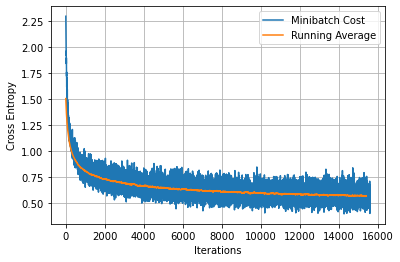

In [20]:
%fit_plot loss

Train accuracy: 83.2807%
Valid accuracy: 87.1667%
Test accuracy: 84.4600%


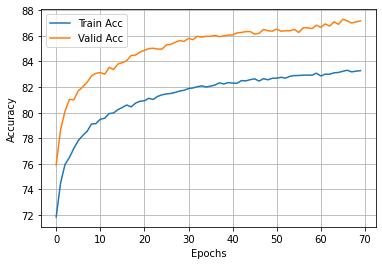

In [21]:
%print_acc 1
%fit_plot acc

In [22]:
torch.manual_seed(random_seed)
num_classes=33; num_filters=4
learning_rate=.05
lcost,lacc_train,lacc_valid=[],[],[]
model=GraphNN(img_size=img_size,
              num_filters=num_filters,
              num_classes=num_classes)
model=model.to(dev)
optimizer=torch.optim.SGD(model.parameters(),
                          lr=learning_rate) 

In [23]:
%train_run 2 300

Epoch: 001/300 | Batch 000/177 | Cost: 3.5010
Epoch: 001/300 | Batch 100/177 | Cost: 3.5095
Epoch: 001/300 train acc: 4.39% valid acc: 3.74%
Epoch: 002/300 | Batch 000/177 | Cost: 3.4784
Epoch: 002/300 | Batch 100/177 | Cost: 3.4718
Epoch: 002/300 train acc: 3.96% valid acc: 3.88%
Epoch: 003/300 | Batch 000/177 | Cost: 3.5043
Epoch: 003/300 | Batch 100/177 | Cost: 3.3795
Epoch: 003/300 train acc: 7.12% valid acc: 6.48%
Epoch: 004/300 | Batch 000/177 | Cost: 3.4139
Epoch: 004/300 | Batch 100/177 | Cost: 3.4150
Epoch: 004/300 train acc: 7.67% valid acc: 7.26%
Epoch: 005/300 | Batch 000/177 | Cost: 3.3442
Epoch: 005/300 | Batch 100/177 | Cost: 3.4043
Epoch: 005/300 train acc: 6.32% valid acc: 6.06%
Epoch: 006/300 | Batch 000/177 | Cost: 3.3102
Epoch: 006/300 | Batch 100/177 | Cost: 3.3201
Epoch: 006/300 train acc: 10.33% valid acc: 8.60%
Epoch: 007/300 | Batch 000/177 | Cost: 3.3455
Epoch: 007/300 | Batch 100/177 | Cost: 3.3223
Epoch: 007/300 train acc: 12.43% valid acc: 11.70%
Epoch: 008

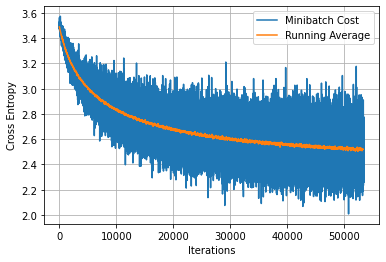

In [24]:
%fit_plot loss

Train accuracy: 30.3383%
Valid accuracy: 28.5412%
Test accuracy: 28.4708%


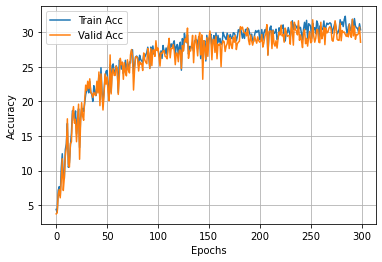

In [25]:
%print_acc 2
%fit_plot acc